# Lab 4

Wyatt Saltzman and Landon Wood  
Dr. Larson  
CS 7324  
October 22, 2023  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read in dataset and confirm df is populated
data = 'acs2017_census_tract_data.csv'
df = pd.read_csv(data)
print(df.shape)
df.head()

(74001, 37)


,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [2]:
# Look at missing values
print(df.isna().sum())
print('Number of rows with missing values:', df.isnull().any(axis=1).sum())

TractId                0
State                  0
County                 0
TotalPop               0
Men                    0
Women                  0
Hispanic             696
White                696
Black                696
Native               696
Asian                696
Pacific              696
VotingAgeCitizen       0
Income              1116
IncomeErr           1116
IncomePerCap         745
IncomePerCapErr      745
Poverty              842
ChildPoverty        1110
Professional         811
Service              811
Office               811
Construction         811
Production           811
Drive                801
Carpool              801
Transit              801
Walk                 801
OtherTransp          801
WorkAtHome           801
MeanCommute          946
Employed               0
PrivateWork          811
PublicWork           811
SelfEmployed         811
FamilyWork           811
Unemployment         810
dtype: int64
Number of rows with missing values: 1283


In [3]:
import copy

# TODO: "Remove any observations with missing data" means remove the rows, right?
# Drop all rows with missing data
df_dropped = copy.deepcopy(df) # Create deep copy of df to avoid overwriting
df_dropped.dropna(axis='index',inplace=True)

# Reset index of df to keep order consistent
df_dropped.reset_index(drop=True, inplace=True)

print('df shape before dropping:', df.shape)
print('df shape after dropping:', df_dropped.shape)
print(df_dropped.isna().sum())
print('Number of rows with missing values:', df_dropped.isnull().any(axis=1).sum())

df shape before dropping: (74001, 37)
df shape after dropping: (72718, 37)
TractId             0
State               0
County              0
TotalPop            0
Men                 0
Women               0
Hispanic            0
White               0
Black               0
Native              0
Asian               0
Pacific             0
VotingAgeCitizen    0
Income              0
IncomeErr           0
IncomePerCap        0
IncomePerCapErr     0
Poverty             0
ChildPoverty        0
Professional        0
Service             0
Office              0
Construction        0
Production          0
Drive               0
Carpool             0
Transit             0
Walk                0
OtherTransp         0
WorkAtHome          0
MeanCommute         0
Employed            0
PrivateWork         0
PublicWork          0
SelfEmployed        0
FamilyWork          0
Unemployment        0
dtype: int64
Number of rows with missing values: 0


In [4]:
# Encode all string data as integers
# Note: label encoding should not be used for state and county in general; these should be one-hot encoded later
# However, the lab specifies to only encode as ints for now
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_dropped['State'] = label_encoder.fit_transform(df_dropped['State'])
df_dropped['County'] = label_encoder.fit_transform(df_dropped['County'])

print('State values after label encoding:', df_dropped['State'].unique())
print('County values after label encoding:', df_dropped['County'].unique())

State values after label encoding: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48
 49 50 51 39]
County values after label encoding: [  89   97  108 ... 1818 1929 1938]


For now, we will keep the County variable in the dataframe. County might not be a strong predictor for child poverty rates,  and because we are only label encoding right now, we have enforced an ordinality that is not intended. However, we can always remove it from the dataframe later if we find it uneccessary or unhelpful, so for now we will keep it in.

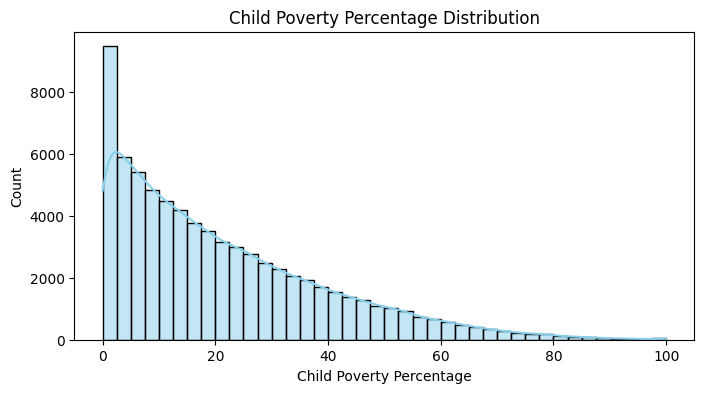

In [5]:
plt.figure(figsize=(8,4))
sns.histplot(df_dropped['ChildPoverty'], bins=40, kde=True, color='skyblue')
plt.xlabel('Child Poverty Percentage')
plt.ylabel('Count')
plt.title('Child Poverty Percentage Distribution')
plt.show()

In [7]:
# Split the ChildPoverty column into bins

# TODO: Why are the bins not covering all instances?
# Looking at the ChildPoverty value_counts, it only sums up to 67,832, or ~93.2% of the original dataset
# Probably just something funcky with the bin edges and stuff, this is also probably not the best way to do it

# TODO: Potentially we should change the bin edges to be more evenly distributed as you can see in the graph I made above.
# We could do 0-10, 10-20, 20-30, and 30+ 

# Define the bin edges and labels for the categories
bin_edges = [0, 25, 50, 75, 100]
bin_labels = [0, 1, 2, 3]

df_processed = df_dropped.copy()

# Use the cut function to create the categorical column
df_processed['ChildPoverty'] = pd.cut(df_processed['ChildPoverty'], bins=bin_edges, labels=bin_labels, include_lowest=True)

child_poverty_counts = df_processed['ChildPoverty'].value_counts()
num_records = 72718

print(df_processed['ChildPoverty'].value_counts())
print('Percentage of child poverty groupings in dataset:')
print('Low:', f"{(child_poverty_counts[0] / num_records) * 100:.2f}%")
print('Moderate:', f"{(child_poverty_counts[1] / num_records) * 100:.2f}%")
print('High:', f"{(child_poverty_counts[2] / num_records) * 100:.2f}%")
print('Very High:', f"{(child_poverty_counts[3] / num_records) * 100:.2f}%")

ChildPoverty
0    47825
1    18400
2     5635
3      858
Name: count, dtype: int64
Percentage of child poverty groupings in dataset:
Low: 65.77%
Moderate: 25.30%
High: 7.75%
Very High: 1.18%


In [8]:
# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X = df_processed.drop('ChildPoverty', axis=1)
y = df_processed['ChildPoverty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(58174, 36)
(58174,)
(14544, 36)
(14544,)


In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

class_distribution = pd.Series(y_train_smote).value_counts()
print('class distribution after SMOTE:', class_distribution)

class distribution after SMOTE: ChildPoverty
0    38230
1    38230
2    38230
3    38230
Name: count, dtype: int64


We chose to use SMOTE (Synthetic Minority Over-sampling Technique) to balance our data because our dataset exhibited a significant class imbalance, with a notably smaller number of instances in the minority classes. In such imbalanced datasets, standard machine learning models may struggle to accurately classify minority classes due to the limited number of examples available for training. SMOTE provides an effective solution by creating synthetic samples for the minority classes, effectively expanding the dataset and making it more balanced. This technique not only mitigates the risk of model bias towards the majority class but also enhances the model's ability to learn from all classes, ultimately leading to improved classification performance.

Balancing the dataset is typically done on the training set only, and not on the testing set. The reason for this is related to the objectives of model training and evaluation. Here's why:

1. **Training Set Balancing**:

   - Balancing the training set helps the machine learning model learn from all classes effectively, particularly when dealing with imbalanced data.
   - In an imbalanced dataset, the model can become biased toward the majority class. By balancing the training set, you ensure that the model is exposed to roughly equal amounts of data from each class, helping it learn the underlying patterns and relationships in all classes.

2. **Testing Set Unaltered**:

   - The testing set is intended to simulate how well your model will perform on real-world, unseen data.
   - Balancing the testing set would artificially alter the class distribution, which doesn't reflect the actual class distribution you would encounter in practice.
   - Balancing the testing set can lead to overly optimistic evaluation results because the model has been trained on a different class distribution.

3. **Realistic Evaluation**:

   - By keeping the testing set unaltered, you ensure that the model's performance evaluation reflects its ability to generalize to the actual, imbalanced distribution that you will encounter in real-world scenarios.
   - This realistic evaluation is crucial for understanding how well your model will perform in practice and making meaningful decisions about its deployment.

In summary, balancing is a preprocessing step that is applied to the training set to help the model learn effectively. The testing set should remain untouched to provide a realistic assessment of your model's performance under real-world class distribution conditions.